# Test computational cost of Stochastic Programming (Scenario Optimisation)

Investigate computational complexity and runtime of scnearios optimisation for system design problem, where each scenario uses a realisation of uncertain battery efficiencies.

In [1]:
import os
import csv
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import inspect
from tqdm import tqdm
from multiprocessing import Pool

from citylearn.citylearn import CityLearnEnv
from linmodel import LinProgModel
from schema_builder import build_schema
from sys_eval import evaluate_system

In [2]:
# set up test parameters
dataset_dir = os.path.join('data','A37_analysis_test') # dataset directory
schema_path = os.path.join(dataset_dir, 'schema.json')
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}

with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
    annex_defaults = json.load(json_file)

In [3]:
# Set up base parameters of system.
ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]

In [4]:
# Set up probabilistic model of effiencies and take draws
n_draws = 100
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_draws,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

In [5]:
num_scenarios = [1,2,3,5,8,10,20]
num_buildings = [1,2,3]

buildings_results = {}

for B in num_buildings:
    runtimes = {}
    for M in num_scenarios:
        if B*M <= 20:
            print(f"# Scenarios: {M}")

            base_kwargs = {
                'output_dir_path': dataset_dir,
                'building_names': ['UCam_Building_%s'%id for id in ids][:B],
                'battery_energy_capacities': [annex_defaults["building_attributes"]["battery_energy_capacities (kWh)"][str(id)] for id in ids][:B],
                'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids][:B],
                'battery_efficiencies': None,
                'pv_power_capacities': [annex_defaults["building_attributes"]["pv_power_capacities (kW)"][str(id)] for id in ids][:B],
                'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids][:B],
                'weather_data_path': 'weather.csv',
                'carbon_intensity_data_path': 'carbon_intensity.csv',
                'pricing_data_path': 'pricing.csv',
                'schema_name': 'schema_temp'
            }

            envs = []

            etas = [eta_samples[k] for k in range(M)] # get M samples

            for m in range(M):
                # Build schema.
                base_kwargs.update({
                        'battery_efficiencies': etas[m][:B]
                    })
                schema_path = build_schema(**base_kwargs)

                # Initialise CityLearn environment object.
                envs.append(CityLearnEnv(schema=schema_path))

                if m == 0: # initialise lp object
                    lp = LinProgModel(env=envs[m])
                else:
                    lp.add_env(env=envs[m])

            lp.set_time_data_from_envs()
            lp.generate_LP(clip_level='m',design=True,pricing_dict=pricing_dict,opex_factor=opex_factor)
            lp.set_LP_parameters()

            start = time.time()
            lp_results = lp.solve_LP(verbose=False,ignore_dpp=True)
            end = time.time()

            print(lp_results['battery_capacities'],lp_results['solar_capacities'])

            runtimes.update({M: end-start})
            print(f"Solve time: {round(runtimes[M],1)}s")

    buildings_results[B] = runtimes

# Scenarios: 1
[1771.89128764] [1074.14965986]
Solve time: 17.2s
# Scenarios: 2
[1772.80167196] [1070.66784388]
Solve time: 74.5s
# Scenarios: 3
[1764.09498902] [1068.42692836]
Solve time: 178.2s
# Scenarios: 5
[1757.18543705] [1061.35009181]
Solve time: 577.3s
# Scenarios: 8
[1766.67841501] [1069.92058092]
Solve time: 1317.7s
# Scenarios: 10
[1760.00158454] [1068.71257485]
Solve time: 2194.1s
# Scenarios: 20
[1756.34964271] [1060.433294]
Solve time: 10647.3s
# Scenarios: 1
[1766.41573866  132.56483915] [1071.13022597   91.72373969]
Solve time: 92.1s
# Scenarios: 2
[1772.64845926  124.63473435] [1070.56094079   91.53898127]
Solve time: 413.7s
# Scenarios: 3
[1764.09498902  126.69103765] [1066.21621622   91.43961313]
Solve time: 1110.3s
# Scenarios: 5
[1757.87828829  123.98024153] [1061.60190009   91.36327943]
Solve time: 3837.1s
# Scenarios: 8
[1766.42756125  124.35725325] [1069.81981982   91.5755316 ]
Solve time: 9270.6s
# Scenarios: 10
[1760.76201174  124.63377823] [1068.71257485   9

In [6]:
print(buildings_results)

{1: {1: 17.16469669342041, 2: 74.52121257781982, 3: 178.18805408477783, 5: 577.2720377445221, 8: 1317.6525468826294, 10: 2194.139812707901, 20: 10647.31181550026}, 2: {1: 92.13854360580444, 2: 413.65667963027954, 3: 1110.2997913360596, 5: 3837.105715274811, 8: 9270.57693529129, 10: 16604.82780480385}, 3: {1: 213.853595495224, 2: 1083.104556798935, 3: 2879.7426328659058, 5: 10384.434494495392}}


In [7]:
# Fit linear trend to log(runtime)
trends = {B: np.polyfit(np.log(list(buildings_results[B].keys())),np.log(list(buildings_results[B].values())),deg=1) for B in num_buildings}
print(trends)

{1: array([2.12936634, 2.84185145]), 2: array([2.25679832, 4.51667858]), 3: array([2.40916065, 5.34309176])}


In [8]:
# Find max allowable samples
runtime_limit = 60*60*24*5
scenarios_limit = np.exp((np.log(runtime_limit) - trends[1][1])/trends[1][0])
print(scenarios_limit)

116.66621598394657


In [15]:
from labellines import labelLines

c:\Users\mal84\.conda\envs\VOI-CAS\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
c:\Users\mal84\.conda\envs\VOI-CAS\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(
c:\Users\mal84\.conda\envs\VOI-CAS\lib\site-packages\labellines\core.py:151: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(
C:\Users\mal84\AppData\Local\Temp\ipykernel_69176\1610368137.py:20: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x000001D01BB76340> starts with '_'. It is thus excluded from the legend.
  ax.legend(labels=[item for t in zip(['_nolegend_']*len(num_buildings),num_buildings) for item in t],title="No. Buildings")
C:\Users\mal84\AppData\Local\Temp\ipykernel_69176\1610368137.py:20: UserWarning: The label '_nolegend_' of <matplotlib.lin

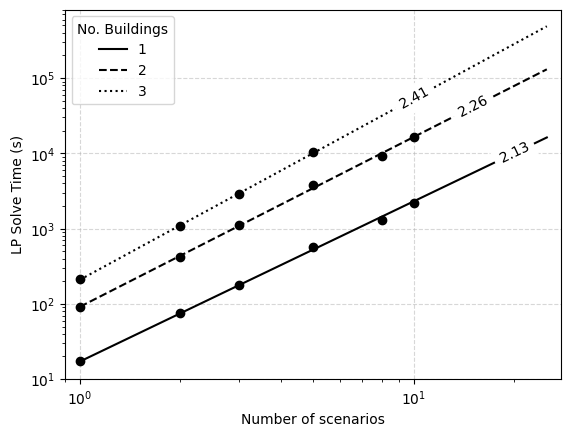

In [44]:
# Plot computational time results
lss = ['-','--',':']
max_scenarios = 25

lines=[]

fig,ax = plt.subplots()
for i,B in enumerate(num_buildings):
    ax.plot(buildings_results[B].keys(),buildings_results[B].values(),'ok')
    line = ax.plot(np.arange(1,max_scenarios+1),np.exp(np.log(np.arange(1,max_scenarios+1))*trends[B][0] + trends[B][1]),c='k',ls=lss[i],label=f"{round(trends[B][0],2)}")
    lines.append(line)
plt.xlabel("Number of scenarios")
plt.xscale('log')
plt.ylabel('LP Solve Time (s)')
plt.yscale('log')
plt.xlim(0.9,max_scenarios*1.1)
plt.ylim(10)
plt.grid(True,'major',alpha=0.5,linestyle='--')
labelLines(ax.get_lines(),xvals=[20,15,10], fontsize=10, backgroundcolor='w')
ax.legend(labels=[item for t in zip(['_nolegend_']*len(num_buildings),num_buildings) for item in t],title="No. Buildings")
plt.show()